# Influence Analysis on MNIST

## Setup 

In [126]:
import logging
from typing import Literal
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Conv1D
from torch import nn
from pathlib import Path
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
from oocr_influence.data import get_data_collator_with_padding
from oocr_influence.logging import load_experiment_checkpoint
from matplotlib.figure import Figure
from matplotlib.axes import Axes

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset
from train import TrainingArgs

## Analysis

### Task

In [127]:
BATCH_TYPE = dict[str, torch.Tensor]


class LanguageModelingTask(Task):
    def compute_train_loss(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits
        logits = logits[..., :-1, :].contiguous()
        logits = logits.view(-1, logits.size(-1))

        if not sample:
            labels = batch["labels"]
            labels = labels[..., 1:].contiguous()
            summed_loss = F.cross_entropy(logits, labels.view(-1), reduction="sum")
        else:
            with torch.no_grad():
                probs = torch.nn.functional.softmax(logits.detach(), dim=-1)
                sampled_labels = torch.multinomial(
                    probs,
                    num_samples=1,
                ).flatten()
            summed_loss = F.cross_entropy(logits, sampled_labels, reduction="sum")
        return summed_loss

    def compute_measurement(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
    ) -> torch.Tensor:
        # We could also compute the log-likelihood or averaged margin.
        return self.compute_train_loss(batch, model)

    def get_influence_tracked_modules(self) -> list[str]:
        total_modules = []

        for i in range(8):
            total_modules.append(f"transformer.h.{i}.attn.c_attn")
            total_modules.append(f"transformer.h.{i}.attn.c_proj")

        for i in range(8):
            total_modules.append(f"transformer.h.{i}.mlp.c_fc")
            total_modules.append(f"transformer.h.{i}.mlp.c_proj")

        return total_modules

    def get_attention_mask(self, batch: BATCH_TYPE) -> torch.Tensor:
        return batch["attention_mask"]


class LanguageModelingTaskMargin(LanguageModelingTask):
    def compute_measurement(self, batch: BATCH_TYPE, model: nn.Module) -> torch.Tensor:
        # Copied from: https://github.com/MadryLab/trak/blob/main/trak/modelout_functions.py. Returns the margin between the correct logit and the second most likely prediction

        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits
        logits = logits[..., :-1, :].contiguous()
        logits = logits.view(-1, logits.size(-1))
        

        labels = batch["labels"][..., 1:].contiguous().view(-1)
        mask = labels == -100
        
        labels = labels[mask]
        logits = logits[mask]

        # Get correct logit values
        bindex = torch.arange(logits.shape[0]).to(
            device=logits.device, non_blocking=False
        )
        logits_correct = logits[bindex, labels]

        # Get the other logits, and take the softmax of them
        cloned_logits = logits.clone()
        cloned_logits[bindex, labels] = torch.tensor(
            -torch.inf, device=logits.device, dtype=logits.dtype
        )
        maximum_non_correct_logits = cloned_logits.logsumexp(dim=-1)

        # Look at the  margin, the difference between the correct logits and the (soft) maximum non-correctl logits
        margins = logits_correct - maximum_non_correct_logits
        return -margins.sum()

## Analysis

In [128]:
experiment_dir = Path(
    "/mfs1/u/max/oocr-influence/outputs/2025_01_13_01:47:32_actually_training_model_final_phi_17.5_num_entities_2000_num_relations_200_relations_per_entity_20_lr_5e-05_max_steps_200000"
)
checkpoint_name = "checkpoint_200000"

factor_strategy: Literal["identity", "diagonal", "kfac", "ekfac"] = (
    "ekfac"  # TODO: Add typesc for the
)
profile_computations = False
use_half_precision = False
compute_per_token_scores = False
use_compile = False
query_batch_size = 32
train_batch_size = 32
query_gradient_rank = -1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [129]:
@torch.no_grad()
def replace_conv1d_modules(model: nn.Module) -> None:
    # GPT-2 is defined in terms of Conv1D. However, this does not work for Kronfluence.
    # Here, we convert these Conv1D modules to linear modules recursively.
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            replace_conv1d_modules(module)

        if isinstance(module, Conv1D):
            new_module = nn.Linear(
                in_features=module.weight.shape[0], out_features=module.weight.shape[1]
            )
            new_module.weight.data.copy_(module.weight.data.t())
            new_module.bias.data.copy_(module.bias.data)
            setattr(model, name, new_module)


model_for_analysis, train_dataset, test_dataset, tokenizer, log = (
    load_experiment_checkpoint(experiment_dir, checkpoint_name)
)
replace_conv1d_modules(model_for_analysis)

model_for_inference = load_experiment_checkpoint(experiment_dir, checkpoint_name)[0]
task = LanguageModelingTask()
model_for_analysis = prepare_model(model_for_analysis, task)


In [130]:
# Compute influence factors.
def get_pairwise_influence_scores(
    analysis_name: str,
    query_name: str,
    train_dataset: Dataset,
    query_dataset: Dataset,
    model: nn.Module,
    task: Task,
    experiment_dir: Path,
) -> torch.Tensor:
    influence_analysis_dir = experiment_dir / "influence"
    analyzer = Analyzer(
        analysis_name=analysis_name,
        model=model,
        task=task,
        profile=profile_computations,
        output_dir=str(influence_analysis_dir),
    )
    # Configure parameters for DataLoader.
    dataloader_kwargs = DataLoaderKwargs(
        collate_fn=get_data_collator_with_padding(tokenizer)
    )
    analyzer.set_dataloader_kwargs(dataloader_kwargs)

    columns_to_remove = [
        c
        for c in train_dataset.column_names
        if c not in ["input_ids", "attention_mask", "labels"]
    ]
    train_dataset, query_dataset = (
        train_dataset.remove_columns(columns_to_remove),
        query_dataset.remove_columns(columns_to_remove),
    )  # type: ignore

    # Compute influence factors.
    factors_name = factor_strategy
    factor_args = FactorArguments(strategy=factor_strategy)
    if use_half_precision:
        factor_args = all_low_precision_factor_arguments(
            strategy=factor_strategy, dtype=torch.bfloat16
        )
        factors_name += "_half"
    if use_compile:
        factors_name += "_compile"
    analyzer.fit_all_factors(
        factors_name=factors_name,
        dataset=train_dataset,
        per_device_batch_size=None,
        factor_args=factor_args,
        initial_per_device_batch_size_attempt=64,
        overwrite_output_dir=False,
    )

    # Compute pairwise scores.
    score_args = ScoreArguments()
    query_name = factor_args.strategy + f"_{analysis_name}" + f"_{query_name}"
    if use_half_precision:
        score_args = all_low_precision_score_arguments(dtype=torch.bfloat16)
        query_name += "_half"
    if use_compile:
        query_name += "_compile"
    if compute_per_token_scores:
        score_args.compute_per_token_scores = True
        query_name += "_per_token"
    rank = query_gradient_rank if query_gradient_rank != -1 else None
    if rank is not None:
        score_args.query_gradient_low_rank = rank
        score_args.query_gradient_accumulation_steps = 10
        query_name += f"_qlr{rank}"
    analyzer.compute_pairwise_scores(
        scores_name=query_name,
        score_args=score_args,
        factors_name=factors_name,
        query_dataset=query_dataset,
        train_dataset=train_dataset,
        per_device_query_batch_size=query_batch_size,
        per_device_train_batch_size=train_batch_size,
        overwrite_output_dir=False,
    )
    scores = analyzer.load_pairwise_scores(query_name)["all_modules"]
    logging.info(f"Scores shape: {scores.shape}")

    return scores

In [159]:
import numpy as np
from typing import Sequence
import matplotlib.pyplot as plt


def plot_histogram(
    data: np.ndarray | list[np.ndarray],
    title: str = "Historgram",
    x_axis_label: str = "Bins",
    y_axis_label: str = "Frequency",
    max_value: int | None = None,
    fig: None | Figure = None,
    axs: None | Axes = None,
    show_fig: bool = True,
) -> None:
    if fig is not None or axs is not None:
        assert fig is not None and axs is not None
    else:
        fig, axs = plt.subplots()

    if max_value is not None:
        data = np.minimum(data, max_value)

    axs.hist(data, bins=50)
    axs.set_title(title)
    axs.set_xlabel(x_axis_label)
    axs.set_ylabel(y_axis_label)

    if show_fig:
        fig.show()


def print_out_top_data(
    influence_scores: np.ndarray,
    train_set: Dataset,
    query_dataset: Dataset,
    num_query: int = 3,
    num_train: int = 100,
    num_datapoints_per_row: int = 5,
):
    influence_scores = np.argsort(-influence_scores, axis=-1)
    query_to_visulise = query_dataset.select(range(num_query))

    for i, query in enumerate(query_to_visulise):
        assert isinstance(query, dict)
        training_points_to_evaluate = influence_scores[i][:num_train]
        output_str = f"ITEM: {query['prompt'] + query['completion']}"

        if "inferred" in query["type"]:
            output_str += (
                f" PARENT 1: {query['parent_fact1']} PARENT 2: {query['parent_fact2']}"
            )

        training_points_to_evaluate = train_set.select(training_points_to_evaluate)

        def add_newlines(str_list):
            for i, string in enumerate(str_list):
                if i % num_datapoints_per_row == 0:
                    yield "\n"

                yield string + ", "

        train_point_str = [
            f"{train_point['prompt'] + train_point['completion']}"
            for train_point in training_points_to_evaluate
        ]  # type: ignore
        train_post_str = "".join(add_newlines(train_point_str))
        output_str += "\n\n" + train_post_str
        print(output_str)


def compare_indexes_of_parent_facts(
    influence_scores: np.ndarray,
    train_set: Dataset,
    query_dataset: Dataset,
    name: str, 
    max_rank_for_hist: int | None = None,
    percentile: int | None = None,
) -> None:
    print("Getting ranks...", end="")

    # 1. Get the ranking (0 = highest rank) from the influence scores
    influence_sorted = np.argsort(np.argsort(-influence_scores, axis=-1), axis=-1)
    print("Done")

    # 2. Correctly extract parent fact indices from the queries
    parent_1_idxs = np.array([q["parent_fact1_ind"] for q in query_dataset])
    parent_2_idxs = np.array([q["parent_fact2_ind"] for q in query_dataset])

    # 3. Get the ranks of each query’s parent facts
    parent_1_rank = influence_sorted[np.arange(len(influence_sorted)), parent_1_idxs]
    parent_2_rank = influence_sorted[np.arange(len(influence_sorted)), parent_2_idxs]

    # 4. Compute average ranks for parent facts
    parent_1_avg_rank = np.mean(parent_1_rank)
    parent_2_avg_rank = np.mean(parent_2_rank)
    
    # Get influence values
    parent_1_influence = influence_scores[np.arange(len(influence_sorted)),parent_1_idxs]
    parent_2_influence = influence_scores[np.arange(len(influence_sorted)),parent_2_idxs]
    
    parent_1_avg_influence = np.mean(parent_1_influence)
    parent_2_avg_influence = np.mean(parent_2_influence)
    
    
    # 5. Separate atomic vs. inferred fact indices from train_set
    train_set_types = np.array(train_set["type"])
    atomic_fact_idxs = np.where(train_set_types == "atomic")[0]
    inferred_fact_idxs = np.where(train_set_types == "train_inferred")[0]

    # 6. Isolate ranks of atomic facts and inferred facts
    atomic_fact_ranks = influence_sorted[:, atomic_fact_idxs]
    inferred_fact_ranks = influence_sorted[:, inferred_fact_idxs]

    atomic_fact_average_influence = np.mean(influence_scores[:,atomic_fact_idxs])

    # 7. Compute average rank for all atomic vs. all inferred facts
    atomic_facts_avg_rank = np.mean(atomic_fact_ranks)
    inferred_facts_avg_rank = np.mean(inferred_fact_ranks)

    # 8. Compare parent ranks specifically among atomic facts
    parent_1_rank_in_atomics = np.sum(
        atomic_fact_ranks < parent_1_rank[:, None],
        axis=-1,
    )
    parent_2_rank_in_atomics = np.sum(
        atomic_fact_ranks < parent_2_rank[:, None], axis=-1
    )

    parent_1_avg_rank_in_atomics = np.mean(parent_1_rank_in_atomics)
    parent_2_avg_rank_in_atomics = np.mean(parent_2_rank_in_atomics)

    fig, axs = plt.subplots(nrows=2, ncols=1)
    plot_histogram(
        parent_1_rank_in_atomics,
        title="Parent 1 rank",
        axs=axs[1],
        fig=fig,
        show_fig=False,
    )
    plot_histogram(
        parent_2_rank_in_atomics,
        title="Parent 2 rank",
        axs=axs[0],
        fig=fig,
        show_fig=False,
    )
    fig.show()

    if percentile is not None:
        parent_1_percentile_in_atomics = np.percentile(
            parent_1_rank_in_atomics, percentile
        )
        parent_2_percentile_in_atomics = np.percentile(
            parent_2_rank_in_atomics, percentile
        )
        fig, axs = plt.subplots(nrows=2, ncols=1)

        plot_histogram(
            parent_1_rank_in_atomics,
            title=f"{name}: Parent 1 rank, top {int(parent_1_percentile_in_atomics)} ({percentile} percentile)",
            max_value=parent_1_percentile_in_atomics,
            axs=axs[1],
            fig=fig,
            show_fig=False,
        )
        plot_histogram(
            parent_2_rank_in_atomics,
            title=f"{name}: Parent 2 rank, top {int(parent_2_percentile_in_atomics)} ({percentile} percentile)",
            max_value=parent_2_percentile_in_atomics,
            axs=axs[0],
            fig=fig,
            show_fig=False,
        )
        fig.show()

    if max_rank_for_hist is not None:
        fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(5,12))
        fig.tight_layout(pad=5.0)
        plot_histogram(
            parent_1_rank_in_atomics,
            title=f"{name}: Parent 1 rank, top {max_rank_for_hist}",
            max_value=max_rank_for_hist,
            axs=axs[0],
            fig=fig,
            show_fig=False,
        )
        plot_histogram(
            parent_2_rank_in_atomics,
            title=f"{name}: Parent 2 rank, top {max_rank_for_hist}",
            max_value=max_rank_for_hist,
            axs=axs[1],
            fig=fig,
            show_fig=False,
        )
        plot_histogram(
            np.max(parent_1_rank_in_atomics) - parent_1_rank_in_atomics,
            title=f"{name}: Parent 1 rank, bottom {max_rank_for_hist}",
            max_value=max_rank_for_hist,
            axs=axs[2],
            fig=fig,
            show_fig=False,
        )
        
        
        fig.show()
    # Print summary statistics
    print(
        f"Parent 1 avg rank: {parent_1_avg_rank}, "
        f"Parent 2 avg rank: {parent_2_avg_rank}, "
        f"Inferred facts avg rank: {inferred_facts_avg_rank}, "
        f"Atomic facts avg rank: {atomic_facts_avg_rank}, "
        f"Parent 1 avg rank in atomics: {parent_1_avg_rank_in_atomics}, "
        f"Parent 2 avg rank in atomics: {parent_2_avg_rank_in_atomics}"
        f"Parent 1 avg influence: {parent_1_avg_influence}"
        f"Parent 2 avg influence: {parent_2_avg_influence}"
        f"Atomic facts avg influence: {atomic_fact_average_influence}" 
    )

def output_self_influence(influence_scores: np.ndarray,top_n=100) -> None:

    influence_sorted = np.argsort(np.argsort(-influence_scores, axis=-1), axis=-1)
    self_index = np.arange(influence_sorted.shape[0])
    
    self_rank = influence_sorted[self_index,self_index]
    plot_histogram(
        self_rank,
        title=f"Self rank",
        max_value=top_n
    )
    
    
    
    
    

QUERY first_100_inferred_test_set
Getting ranks...Done
Parent 1 avg rank: 90597.29, Parent 2 avg rank: 11222.13, Inferred facts avg rank: 369858.53648904286, Atomic facts avg rank: 372466.36144175, Parent 1 avg rank in atomics: 4886.75, Parent 2 avg rank in atomics: 604.97Parent 1 avg influence: 85.36973571777344Parent 2 avg influence: 4.607748985290527Atomic facts avg influence: -0.005643128417432308
ITEM: <e0><r198><r6><e950> PARENT 1: <e0><r198><e93> PARENT 2: <e93><r6><e950>


<e1262><r71><r37><e697>, <e1981><r104><r37><e697>, <e671><r50><r65><e1018>, <e1223><r166><r69><e1421>, <e1193><r136><r37><e697>, 
<e1433><r188><r6><e1150>, <e905><r80><r176><e1537>, <e1923><r21><r72><e1621>, <e815><r56><r191><e924>, <e1490><r121><r103><e1090>, 
<e1775><r177><r6><e950>, <e707><r11><r134><e1791>, <e529><r94><r152><e1424>, <e1329><r196><r6><e19>, <e771><r59><r30><e1194>, 
<e1329><r196><r189><e1489>, <e974><r132><r6><e476>, <e1329><r196><e1778>, <e677><r170><r129><e88>, <e7><r85><r173><e1404>, 
<

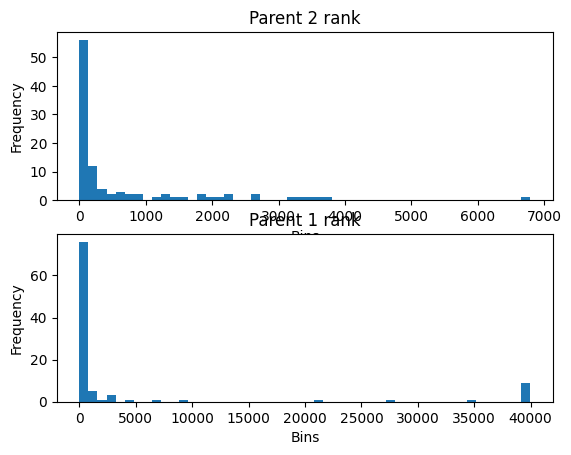

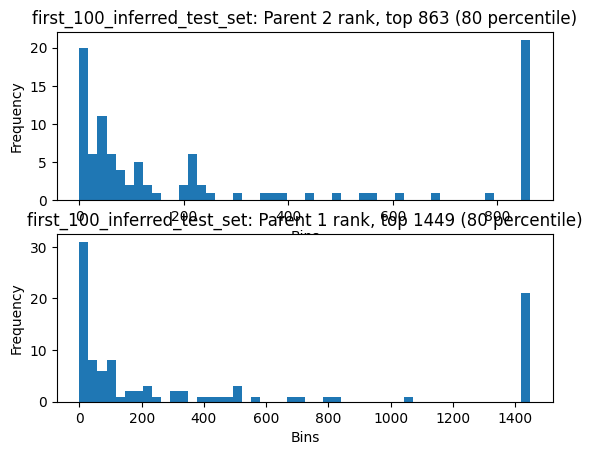

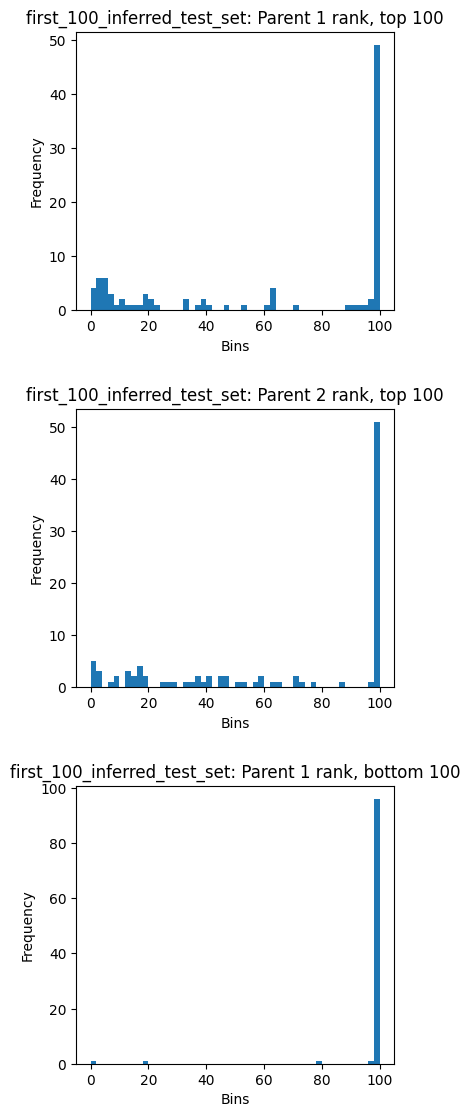

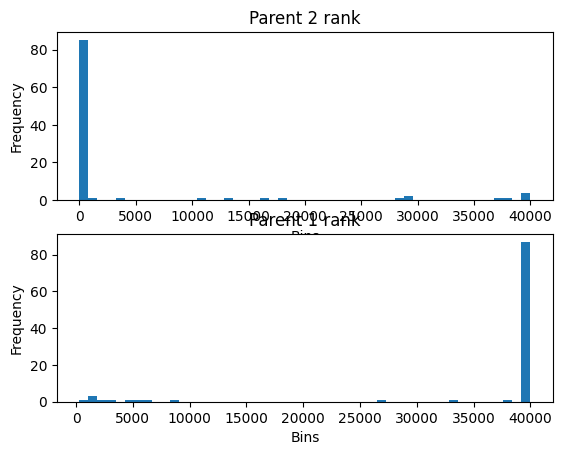

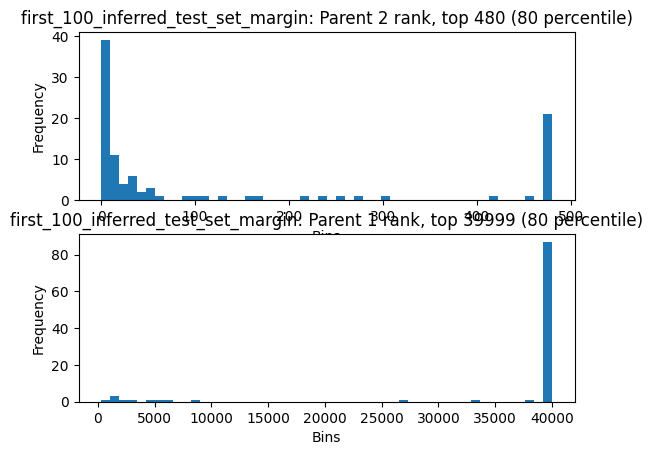

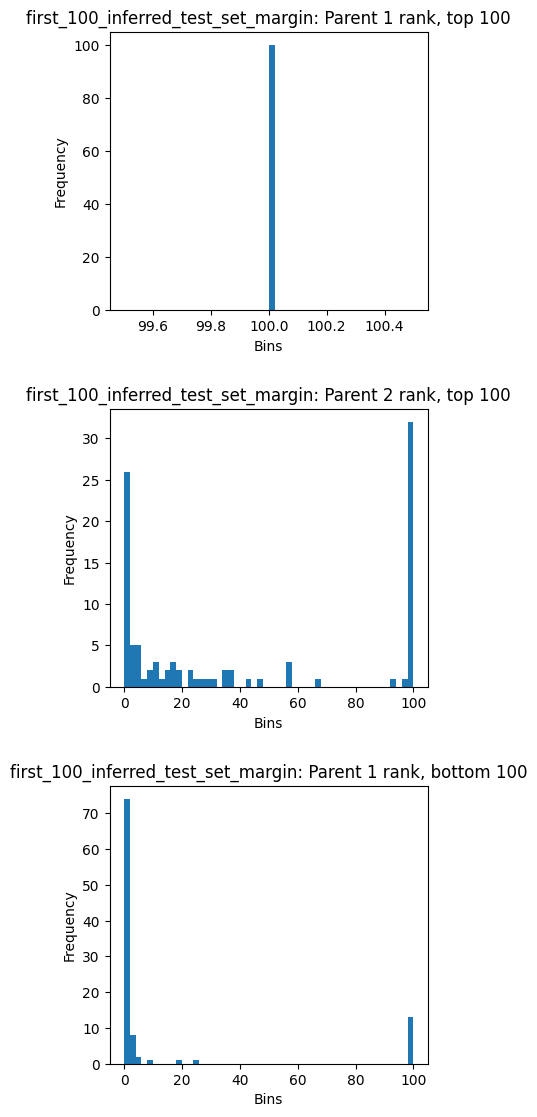

In [162]:
test_dataset_only_inferred = test_dataset.filter(lambda x: "inferred_iid" in x["type"])
queries = {
    "first_100_inferred_test_set": test_dataset_only_inferred.select(range(100)),
    # "first_10_train_set": train_dataset.select(range(10)),
}
include_margin = True


if include_margin:
    model_for_analysis_margin = load_experiment_checkpoint(
        experiment_dir, checkpoint_name
    )[0]
    replace_conv1d_modules(model_for_analysis_margin)
    task_margin = LanguageModelingTaskMargin()
    model_for_analysis_margin = prepare_model(model_for_analysis_margin, task_margin)
    queries = queries | {
        # "first_100_inferred_test_set_margin2": {
        #     "dataset": test_dataset_only_inferred.select(range(100)),
        #     "task": task_margin,
        #     "model": model_for_analysis_margin,
        #     "name": "margin",
        # },
        "first_100_inferred_test_set_margin": {
            "dataset": test_dataset_only_inferred.select(range(100)),
            "task": task_margin,
            "model": model_for_analysis_margin,
            "name": "margin",
        },
        # "first_100_train_set_margin": {
        #     "dataset": train_dataset.select(range(100)),
        #     "task": task_margin,
        #     "model": model_for_analysis_margin,
        #     "name": "margin",
        # },
    }


for query_name, query_dict_or_dataset in queries.items():
    print(f"QUERY {query_name}")
    analysis_name = "pairwise_influence_train_to_test"
    query_task = task

    if isinstance(query_dict_or_dataset, dict):
        query_dataset = query_dict_or_dataset["dataset"]
        query_task = query_dict_or_dataset["task"]
        model = query_dict_or_dataset["model"]
        if "name" in query_dict_or_dataset:
            analysis_name += f'_{query_dict_or_dataset["name"]}'
    else:
        query_dataset = query_dict_or_dataset

    assert isinstance(query_dataset, Dataset)
    assert isinstance(query_task, Task)

    influence = (
        get_pairwise_influence_scores(
            analysis_name=analysis_name,
            train_dataset=train_dataset,
            query_dataset=query_dataset,
            query_name=query_name,
            experiment_dir=experiment_dir,
            model=model_for_analysis,
            task=query_task,
        )
        .cpu()
        .numpy()
    )
    if "inferred_test_set" in query_name:
        compare_indexes_of_parent_facts(
            influence,
            name=query_name,
            train_set=train_dataset,
            query_dataset=query_dataset,
            max_rank_for_hist=100,
            percentile=80,
        )
        print_out_top_data(
            influence_scores=influence,
            train_set=train_dataset,
            query_dataset=query_dataset,
        )
    elif "train" in query_name:
        output_self_influence(influence)